## Impact of TOP/Sub-orbital Total Electron Content (TEC) on SAR range delay

Dataset: Chile Sen asc track 149

+ Figure 1. Residual RMSE of (SAR - TECgim - SET - ERA5) vs. (SAR - TECsub - SET - ERA5)
+ Figure 2. Time-series of GIM/SUB/TOP_TEC and its predicted range delay for X/C/S/L-band SAR

In [1]:
%matplotlib inline
import os
import h5py
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt, ticker, dates as mdates, colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable

from mintpy.objects import timeseries
from mintpy.utils import ptime, readfile, utils as ut, plot as pp
from tools.simulation import iono
plt.rcParams.update({'font.size': 12})
#plt.rcParams.update({'lines.linewidth': 2.0})

# location of interest
win = 9  # size of the window of interest where the median offset is calculated
lalo = [-21.29, -69.58]; box_suffix = 'boxCL'   # box in the center left with low  altitude; box = (10,  55,  20, 70) for SenAT149
lalo = [-21.30, -67.39]; box_suffix = 'boxLR'   # box in the lower right with high altitude; box = (200, 15, 215, 30) for SenAT149

# dir
proj_dir = os.path.expanduser('~/data/geolocation/ChileSenAT149')
proj_name = os.path.basename(proj_dir)

work_dir = os.path.join(proj_dir, 'offset_comp', box_suffix)
os.chdir(work_dir)
print('Go to directory', work_dir)

Go to directory /Users/yunjunz/data/geolocation/ChileSenAT149/offset_comp/boxLR


## Figure - TS residual: gimTEC vs. subTEC

### 1. Generate HDF5/MintPy files

In [6]:
os.chdir(os.path.join(proj_dir, 'mintpy_offset'));  print('Go to directory:', os.path.join(proj_dir, 'mintpy_offset'))

# residual TS with gimTEC
!add.py  timeseriesRg.h5            inputs/gimTEC.h5 -o timeseriesRg_gimTEC.h5
!reference_date.py timeseriesRg_gimTEC.h5 -t ChileSenAT149.txt --force
!diff.py timeseriesRg_gimTEC.h5     inputs/SET.h5    -o timeseriesRg_gimTEC_SET.h5
!diff.py timeseriesRg_gimTEC_SET.h5 inputs/ERA5.h5   -o timeseriesRg_gimTEC_SET_ERA5.h5

# residual TS with subTEC
!add.py  timeseriesRg.h5            inputs/subTEC.h5 -o timeseriesRg_subTEC.h5
!reference_date.py timeseriesRg_subTEC.h5 -t ChileSenAT149.txt --force
!diff.py timeseriesRg_subTEC.h5     inputs/SET.h5    -o timeseriesRg_subTEC_SET.h5
!diff.py timeseriesRg_subTEC_SET.h5 inputs/ERA5.h5   -o timeseriesRg_subTEC_SET_ERA5.h5

os.chdir(work_dir);  print('Go to directory:', work_dir)

Go to directory: /Users/yunjunz/data/geolocation/ChileSenAT149/mintpy_offset
setenv: Variable name must contain alphanumeric characters.
input files to be added: (2)
['timeseriesRg.h5', 'inputs/gimTEC.h5']
adding timeseries ...
use metadata from the 1st file: timeseriesRg.h5
delete exsited file: timeseriesRg_gimTEC.h5
create HDF5 file: timeseriesRg_gimTEC.h5 with w mode
create dataset /timeseries of float32    in size of (104, 123, 231)      with compression=None
create dataset /bperp      of float32    in size of (104,)     with compression=None
create dataset /date       of |S8        in size of (104,)     with compression=None
finished writing to timeseriesRg_gimTEC.h5
Done.
setenv: Variable name must contain alphanumeric characters.
input reference date: 20200123
--------------------------------------------------
change reference date for file: /Users/yunjunz/data/geolocation/ChileSenAT149/mintpy_offset/timeseriesRg_gimTEC.h5
reading data ...
referencing in time ...
---------------

### 2. Read & Plot

/Users/yunjunz/tools/miniconda3/envs/insar/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1114: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)


save figure to file /Users/yunjunz/data/geolocation/ChileSenAT149/offset_comp/boxLR/TS_res_subTEC_vs_gimTEC.png


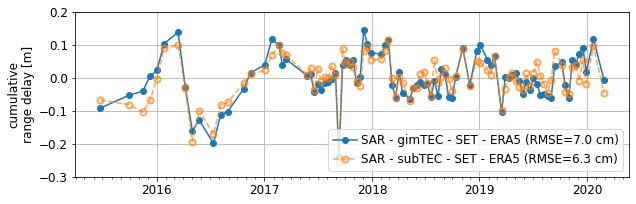

In [2]:
### Read data
ts_file1 = os.path.join(proj_dir, 'mintpy_offset/timeseriesRg_gimTEC_SET_ERA5.h5')
ts_file2 = os.path.join(proj_dir, 'mintpy_offset/timeseriesRg_subTEC_SET_ERA5.h5')
geom_file = os.path.join(proj_dir, 'mintpy_offset/inputs/geometryRadar.h5')

# date info
date_list = timeseries(ts_file1).get_date_list()
dates = np.array(ptime.date_list2vector(date_list)[0])
num_date = len(date_list)

# lalo --> box
atr = readfile.read_attribute(ts_file1)
coord = ut.coordinate(atr, lookup_file=geom_file)
y, x = coord.geo2radar(lalo[0], lalo[1])[:2]
win2 = int(win/2)
box = (x-win, y-win, x+win+1, y+win+1)

# read
ts1 = np.nanmedian(readfile.read(ts_file1, box=box)[0].reshape(num_date, -1), axis=-1)
ts2 = np.nanmedian(readfile.read(ts_file2, box=box)[0].reshape(num_date, -1), axis=-1)

# omit dates without GIM/SUB_TEC
sub_tec_file = os.path.join(proj_dir, 'mintpy_offset/inputs/subTEC.h5')
ts_tec = np.nanmedian(readfile.read(sub_tec_file, box=box)[0].reshape(num_date, -1), axis=-1)

flag = ~np.isnan(ts_tec)
dates = dates[flag]
ts1 = ts1[flag]
ts2 = ts2[flag]
ts1 -= np.nanmean(ts1)
ts2 -= np.nanmean(ts2 - ts1)
rmse1 = ut.root_mean_sq_error(ts1)
rmse2 = ut.root_mean_sq_error(ts2)
label1 = 'SAR - gimTEC - SET - ERA5 (RMSE={:.1f} cm)'.format(rmse1*100)
label2 = 'SAR - subTEC - SET - ERA5 (RMSE={:.1f} cm)'.format(rmse2*100)


### plot

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[9, 3])
# bar plot
#xstep = np.min(np.diff(dates)) / 2 * (5/6)
#ax.bar(dates - xstep/2, ts1, width=xstep, label='SAR-gimTEC-SET-ERA5 (RMSE={:.1f} cm)'.format(rmse1))
#ax.bar(dates + xstep/2, ts2, width=xstep, label='SAR-subTEC-SET-ERA5 (RMSE={:.1f} cm)'.format(rmse2))
# dot plot
ax.plot(dates, ts1, 'o-',  mew=1, mfc='C0',   label=label1)
ax.plot(dates, ts2, 'o--', mew=2, mfc='none', label=label2, alpha=0.7)

# axis format
pp.auto_adjust_xaxis_date(ax, dates, every_year=1, buffer_year=None)
ax.set_ylabel('cumulative\nrange delay [m]')
ax.set_ylim(-0.3, 0.2)
ax.legend(loc='lower right', handletextpad=0.3)
ax.grid('on')
fig.tight_layout()

# output
out_fig = os.path.join(work_dir, 'TS_res_subTEC_vs_gimTEC.png')
print('save figure to file', out_fig)
#plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

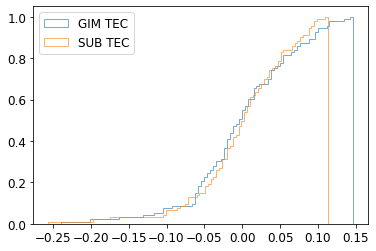

In [3]:
fig, ax = plt.subplots(figsize=[6, 4])
ax.hist(ts1, bins=100, cumulative=True, density=True, histtype='step', alpha=0.6, label='GIM TEC')
ax.hist(ts2, bins=100, cumulative=True, density=True, histtype='step', alpha=0.6, label='SUB TEC')
#ax.set_ylim(0, 1)
ax.legend(loc='upper left')
plt.show()

## Figure - Ionospheric Impact on C-/S-/L-band SAR

### 1. Read data

In [4]:
geom_file = os.path.join(proj_dir, 'mintpy_offset/inputs/geometryRadar.h5')
tec_file  = os.path.join(proj_dir, 'mintpy_offset/inputs/subTEC.h5')

# geometry
(iono_inc_angle,
 iono_lat,
 iono_lon,
 iono_height) = iono.prep_geometry_iono_shell_along_los(geom_file)
iono_inc_angle = np.nanmedian(iono_inc_angle)

# TEC
tec_dict = {}
with h5py.File(tec_file, 'r') as f:
    tec_dict['TOP TEC'] = f['vtec_top'][:]
    tec_dict['SUB TEC'] = f['vtec_sub'][:]
    tec_dict['GIM TEC'] = f['vtec_gim'][:]

# time
date_list = timeseries(tec_file).get_date_list()
dates = ptime.date_list2vector(date_list)[0]

# stats
for key, value in tec_dict.items():
    print('{} min/max: {:.2f} / {:.2f}'.format(key, np.nanmin(value), np.nanmax(value)))

incidence angle on the ground     min/max: 30.0/46.1 deg
incidence angle on the ionosphere min/max: 27.9/42.3 deg
center lat/lon  on the ground    : -21.0438/-68.4108 deg
center lat/lon  on the ionosphere: -18.1416/-69.1286 deg
TOP TEC min/max: 3.34 / 11.47
SUB TEC min/max: 0.35 / 48.67
GIM TEC min/max: 6.59 / 59.11


/Users/yunjunz/tools/dev/tools/simulation/iono.py:127: RuntimeWarning: invalid value encountered in sin
  cos_inc_angle_iono = np.sqrt(1 - (EARTH_RADIUS * np.sin(inc_angle) / (EARTH_RADIUS + iono_height))**2)


### 2. Plot

number of TOP TEC: 93
number of SUB TEC: 93
number of GIM TEC: 104
save figure to file /Users/yunjunz/data/geolocation/ChileSenAT149/offset_comp/topTEC_pred.pdf


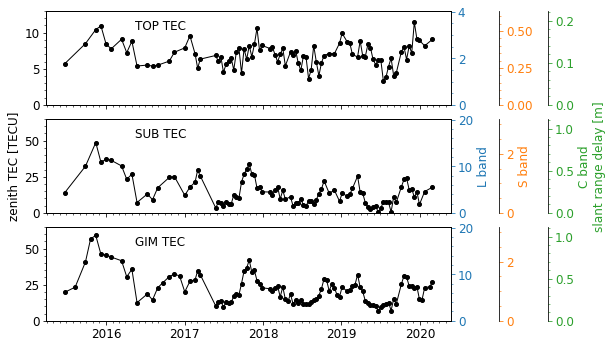

In [9]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=[9, 5], sharex=True)
for i, (ax, tec_type, ymax, ystep) in enumerate(zip(axs, tec_dict.keys(), [13, 65, 65], [1, 5, 5])):
    ts_tec = tec_dict[tec_type]
    # omit nan values
    flag = ~np.isnan(ts_tec)
    ts_tec = np.array(ts_tec)[flag]
    x = np.array(dates)[flag]
    print('number of {}: {}'.format(tec_type, np.sum(flag)))

    # plot
    ax.plot(x, ts_tec, '-o', label=tec_type, color='k', ms=4, lw=1)
    ax.set_ylim(0, ymax)
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(ystep))
    ax.annotate(tec_type, xy=(0.22, 0.8), xycoords='axes fraction', color='k', ha='left')

    # predicted range delay
    for j, (bname, c) in enumerate(zip(iono.SAR_BAND.keys(), ['C0', 'C1', 'C2'])):
        # calculate
        ts_delay = iono.vtec2range_delay(ts_tec, inc_angle=iono_inc_angle, freq=iono.SAR_BAND[bname])

        # add y-axis
        ax2 = ax.twinx()
        ax2.spines['right'].set_position(('axes', 1.0+0.12*j))
        ax2.tick_params(which='both', axis='y', colors=c)
        ax2.yaxis.set_minor_locator(ticker.AutoMinorLocator())

        # ylabel
        if i == 1:
            label = '{} band'.format(bname)
            label += '\nslant range delay [m]' if j == 2 else ''
            ax2.set_ylabel(label, color=c)

        # ylim sync btw. ax and ax2
        ratio = ((np.max(ts_delay) - np.min(ts_delay)) / (np.max(ts_tec)   - np.min(ts_tec)))
        ax2.set_ylim(np.array(ax.get_ylim()) * ratio)
        ## test
        #ax2.plot(x, ts_delay, 'o', mfc='none')

# axis format
pp.auto_adjust_xaxis_date(ax, dates, every_year=1, buffer_year=None)
axs[1].set_ylabel('zenith TEC [TECU]')
fig.tight_layout()
fig.subplots_adjust(hspace=0.15)

# output
out_fig = os.path.join(proj_dir, 'offset_comp/topTEC_pred.pdf')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

## Figure - Percentage of TOP TEC

save figure to file /Users/yunjunz/data/geolocation/ChileSenAT149/offset_comp/topTEC_perc.pdf


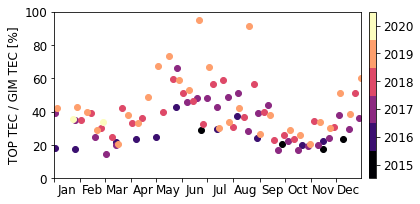

In [8]:
# prepare data
perc = tec_dict['TOP TEC'] / tec_dict['GIM TEC'] * 100

years = sorted(list(set([d.year for d in dates])))
num_year = len(years)
year0 = 2016

# plot
fig, ax = plt.subplots(figsize=[6, 3])
cmap = plt.get_cmap('magma', lut=num_year)
for i, year in enumerate(years):
    flag = np.array([d.year == year for d in dates], dtype=np.bool_)
    xs = np.array(dates)[flag]
    xs = [x.replace(year=year0) for x in xs]
    ax.plot(xs, perc[flag], 'o', c=cmap(i))

# axis format
ax.set_ylabel('TOP TEC / GIM TEC [%]')
ax.set_ylim(0, 100)
ax.set_xlim(dt.datetime(year0, 1, 1), dt.datetime(year0, 12, 31))
# centering labels beetween ticks (https://matplotlib.org/stable/gallery/ticks_and_spines/centered_ticklabels.html)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator(bymonthday=16))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))
for tick in ax.xaxis.get_minor_ticks():
    tick.tick1line.set_markersize(0)
    tick.tick2line.set_markersize(0)
    tick.label1.set_horizontalalignment('center')

# colorbar
cticks = (np.arange(num_year) + 0.5) / num_year
cax = make_axes_locatable(ax).append_axes('right', 0.1, pad=0.1, axes_class=plt.Axes)
cbar = colorbar.ColorbarBase(cax, cmap=cmap, ticks=cticks)
cbar.ax.set_yticklabels(years)

fig.tight_layout()
# output
out_fig = os.path.join(proj_dir, 'offset_comp/topTEC_perc.pdf')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()

save figure to file /Users/yunjunz/data/geolocation/ChileSenAT149/offset_comp/topTEC_perc.pdf


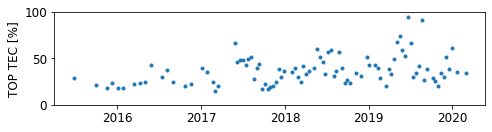

In [95]:
## obsolete
fig, ax = plt.subplots(figsize=[7, 2])
ax.plot(dates, tec_dict['TOP TEC']/tec_dict['GIM TEC'] * 100, '.')
ax.set_ylabel('TOP TEC [%]')
ax.set_ylim(0, 100)
fig.tight_layout()

# output
out_fig = os.path.join(proj_dir, 'offset_comp/topTEC_perc.pdf')
print('save figure to file', out_fig)
#plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()